In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import re

In [10]:
df = pd.read_csv('full_data_2011-01-01_2022-11-26.csv', sep=',')

df = df.loc[[2]].drop(columns='Unnamed: 0').T
df.columns = ['Precipitation']
df['The_date'] = df['Precipitation']
df.head()

,Precipitation,The_date
01 Jan 11 Daily peak [MW],3460.0,3460.0
02 Jan 11 Daily peak [MW],3280.0,3280.0
03 Jan 11 Daily peak [MW],3577.0,3577.0
04 Jan 11 Daily peak [MW],3318.0,3318.0
05 Jan 11 Daily peak [MW],3397.0,3397.0


In [11]:
dict_month = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08','Sep': '09','Oct': '10','Nov': '11','Dec': '12'}

for i in range(len(df)):
    day = "".join(re.findall("\d", df.index[i].split(" ", 1)[0]))
    month = dict_month[df.index[i].split(" ")[1]]
    year = "".join(re.findall("\d", df.index[i].split(" ", 1)[1]))
    
    the_date = f'{day}-{month}-{year}'
        
    df['The_date'].iloc[i] = the_date
    
df['The_date'] = pd.to_datetime(df['The_date'])

In [6]:
train = df['Precipitation'][:4000]
test = df['Precipitation'][4000:]

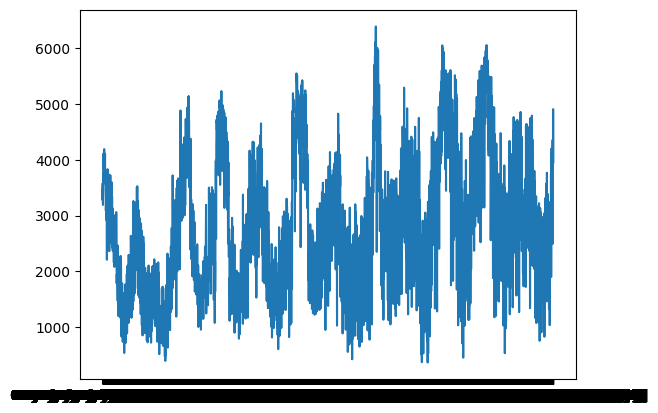

In [7]:
plt.plot(df['Precipitation'])

In [8]:
result_add = seasonal_decompose(df['Precipitation'][:1000], model='additive')
result_mul = seasonal_decompose(df['Precipitation'][:1000], model='multiplicative')

result_add

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
from statsmodels.tsa.stattools import adfuller
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multiplicative resid: ', adfuller(result_mul.resid.dropna())[1])

In [ ]:
plot_acf(df['Precipitation'][:1000], lags=100);
plot_pacf(df['Precipitation'][:1000], lags=50, c='r');

In [ ]:
zero_diff = df['Precipitation'][:1000]
first_order_diff = df['Precipitation'][:1000].diff(1)
second_order_diff = df['Precipitation'][:1000].diff(1).diff(1)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');


In [ ]:
p = 8
d = 1
q = 10

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(df['Precipitation'], order = (8,1,10), trend='t')
arima = arima.fit()

arima.summary()

In [ ]:
import pmdarima as pm
smodel = pm.auto_arima(df['Precipitation'],
                       start_p=0, max_p=2,
                       start_q=0, max_q=20,
                       trend='t',
                       seasonal=True,
                       trace=True)

In [ ]:
forecast_results = arima.get_forecast(len(test), alpha=0.05, start='01-01-11', end='01-01-19')

In [ ]:
arima = ARIMA(train, order=(8,1,10))
arima = arima.fit()

forecast = arima.forecast(len(test), alpha=0.05)

forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);
    
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1]);

In [ ]:
import pmdarima as pm
smodel = pm.auto_arima(y_train, seasonal=True, m=1, 
                       start_p=0, max_p=1, max_d=1, start_q=0, max_q=1,
                       start_P=0, max_P=2, max_D=1, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict

arima = ARIMA(train, order=(8,1,10))
arima = arima.fit()

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(df['Precipitation'], label='Real')
plot_predict(arima, start=0, end=5000, ax=axs);

In [ ]:
df